In [1]:
import extract_eye_models
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt

try:
    from tqdm import trange
except ImportError:
    trange = range

The first task is calculating a threshold. In my experience, this seems to stay pretty constant, so I don't bother doing the computational work of calculating it anew for every frame. This does limit the applicability somewhat; for instance, background-subtracted images tend to fluctuate in brightness, breaking this assumption.

The thresholding algorithm is called Intermodes, and it works by putting the thresholds in between the two peaks of the image brightness histogram. If there are more than two peaks, it smooths out the histogram until there are only two. Experimentally, it works much better than Otsu's method on differentiating the eyes from the background (try it out in ImageJ).

In [2]:
img0 = imread('Z:/TrackerRig/2018-02-15/SequenceB00000000.tif')
threshold = extract_eye_models.intermodes(img0)
print(threshold)

73


This is the most important part of the program. `extract_eye_models` detects blobs of pixels that approximate the eyes. It returns an array of two eyes, which it represents with the following tuple of properties:
* x-coordinate of center
* y-coordinate of center
* major axis length
* minor axis length
* orientation

In [3]:
eyes1 = []
eyes2 = []
for i in trange(3000):
    img = imread('Z:/TrackerRig/2018-02-15/SequenceB{:08d}.tif'.format(i))
    [eye1, eye2] = extract_eye_models.eye_models(img < threshold)
    eyes1.append(eye1)
    eyes2.append(eye2)

100%|██████████| 3000/3000 [09:19<00:00,  5.36it/s]


This part ensures that which eye is which is consistent across multiple frames, so that it becomes meaningful to look at the orientation of a single eye over time. Eye A or B does not necessarily correspond to left or right, but a program to determine that would now only need to examine the first frame, and this function could take it from there. It does this
by looking for the eye blob closest to the eye blob in the previous frame.

In [4]:
eyesA, eyesB = extract_eye_models.correlate(eyes1, eyes2)

This extracts the orientation of each eye (index 4 in the tuple), and computes the angle difference (in radians). This does not just use subtraction, so it is a valid measure of the seperation of the angles.

In [5]:
Δθ = extract_eye_models.angle_difference(np.array(eyesA)[:, 4], np.array(eyesB)[:, 4])

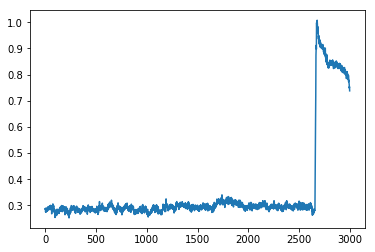

In [10]:
plt.plot(Δθ)
plt.show()

This graph shows a really sharp spike right around index 2650, and indeed if you open the files, you see a pretty dramatic inward orientation of the eyes.